In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn
from torch import optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchvision import datasets, transforms
from tqdm import tqdm

from src.VAE import LinearVAE

In [2]:
encoder1 = nn.Sequential(nn.Linear(28 * 28, 256),
                         nn.ReLU(),
                         nn.Linear(256, 128),
                         nn.ReLU())
decoder1 = nn.Sequential(nn.Linear(64, 128),
                         nn.ReLU(),
                         nn.Linear(128, 256),
                         nn.ReLU(),
                         nn.Linear(256, 28 * 28),
                         nn.Sigmoid())
encoder2 = nn.Sequential(nn.Linear(28 * 28, 256))
decoder2 = nn.Sequential(nn.Linear(256, 28 * 28))
vae = LinearVAE(encoder1, decoder1, 128, 64)

In [3]:
def KLD(mu: torch.Tensor, log_var: torch.Tensor):
    return -0.5 * torch.mean(1 + log_var - mu.pow(2) - log_var.exp())


def BCE(recon: torch.Tensor, X: torch.Tensor):
    return nn.functional.binary_cross_entropy(recon, X, reduction='mean')


def L1Loss(recon: torch.Tensor, X: torch.Tensor):
    return nn.functional.l1_loss(recon, X, reduction='mean')


def L2Loss(recon: torch.Tensor, X: torch.Tensor):
    return nn.functional.mse_loss(recon, X, reduction='mean')

In [43]:
transform = transforms.Compose([
    transforms.ToTensor()
])
dataset1 = datasets.MNIST('../data', train=True, download=True,
                          transform=transform)
dataset2 = datasets.MNIST('../data', train=False,
                          transform=transform)
train_loader = torch.utils.data.DataLoader(dataset1, batch_size=1024, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset2, batch_size=10000)

## KLD and BCE

In [123]:
model = vae.to('cuda')
optimizer = optim.Adadelta(model.parameters(), lr=1e-1)
scheduler = ReduceLROnPlateau(optimizer, factor=0.1, patience=5, verbose=False, threshold=1e-3)

In [124]:
def train(model, train_loader, optimizer, epoch):
    model.train()
    allLoss = []
    allReconLoss = []
    with tqdm(train_loader, unit='batch') as tEpoch:
        for data, _ in tEpoch:
            data = data.to('cuda').view(-1, 28 * 28)
            optimizer.zero_grad()
            output, mu, log_var = model(data)
            reconLoss = BCE(output, data)
            loss = KLD(mu, log_var)
            loss.backward()
            optimizer.step()
            allLoss.append(loss.item())
            allReconLoss.append(reconLoss.item())
            tEpoch.set_postfix_str(' Epoch: {} \tTotal Loss: {:.6f}\tReconstruction Loss: {:.6f}\t lr: {:.8f}'.format(
                epoch, loss.item(), reconLoss.item(), optimizer.param_groups[0]['lr']))
    return allLoss, allReconLoss

In [125]:
for epoch in range(1, 201):
    _, loss = train(model, train_loader, optimizer, epoch)
    scheduler.step(np.mean(loss))

 20%|██        | 12/59 [00:01<00:04, 11.61batch/s,  Epoch: 27 	Total Loss: 0.000000	Reconstruction Loss: 0.262823	 lr: 0.00001000]


KeyboardInterrupt: 

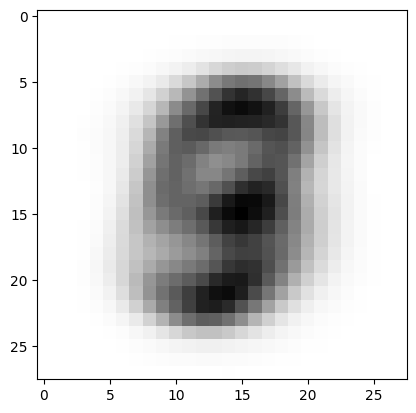

In [126]:
z = torch.normal(0, 1, size=(1, 64)).cuda()
plt.imshow(model.sample(z).cpu().detach().view(28, 28), cmap='Greys')

In [89]:
img0 = next(iter(train_loader))[0][0]

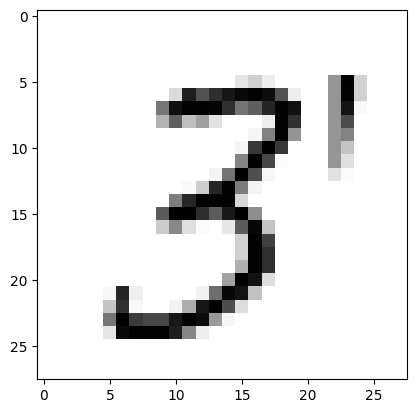

In [90]:
plt.imshow(img0[0], cmap='Greys')

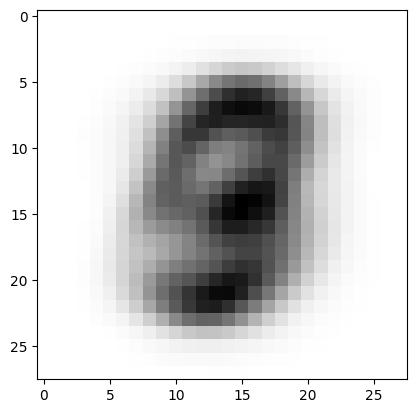

In [91]:
output, _, _ = model(img0.view(-1, 28 * 28).cuda())
plt.imshow(output.cpu().detach().view(28, 28), cmap='Greys')

## Only BCE

In [62]:
model = vae.to('cuda')
optimizer = optim.Adadelta(model.parameters(), lr=1e1)
scheduler = ReduceLROnPlateau(optimizer, factor=0.1, patience=5, verbose=False, threshold=1e-3)

In [63]:
def train(model, train_loader, optimizer, epoch):
    model.train()
    allLoss = []
    allReconLoss = []
    with tqdm(train_loader, unit='batch') as tEpoch:
        for data, _ in tEpoch:
            data = data.to('cuda').view(-1, 28 * 28)
            optimizer.zero_grad()
            output, mu, log_var = model(data)
            reconLoss = BCE(output, data)
            loss = reconLoss
            loss.backward()
            optimizer.step()
            allLoss.append(loss.item())
            allReconLoss.append(reconLoss.item())
            tEpoch.set_postfix_str(' Epoch: {} \tTotal Loss: {:.6f}\tReconstruction Loss: {:.6f}\t lr: {:.8f}'.format(
                epoch, loss.item(), reconLoss.item(), optimizer.param_groups[0]['lr']))
    return allLoss, allReconLoss

In [64]:
for epoch in range(1, 201):
    _, loss = train(model, train_loader, optimizer, epoch)
    scheduler.step(np.mean(loss))

 88%|████████▊ | 52/59 [00:04<00:00, 11.84batch/s,  Epoch: 126 	Total Loss: 0.081188	Reconstruction Loss: 0.081188	 lr: 1.00000000]


KeyboardInterrupt: 

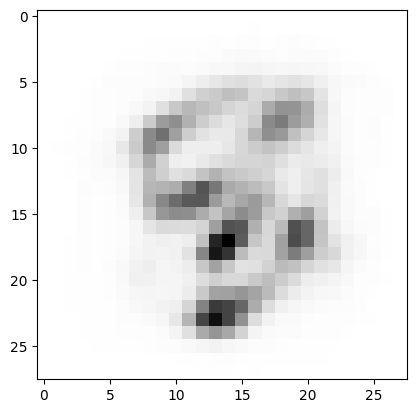

In [65]:
z = torch.normal(0, 1, size=(1, 64)).cuda()
plt.imshow(model.sample(z).cpu().detach().view(28, 28), cmap='Greys')

In [66]:
img0 = next(iter(train_loader))[0][0]

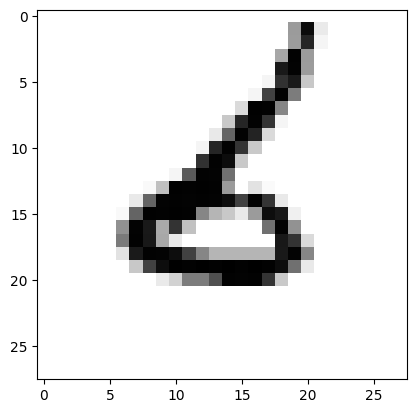

In [67]:
plt.imshow(img0[0], cmap='Greys')

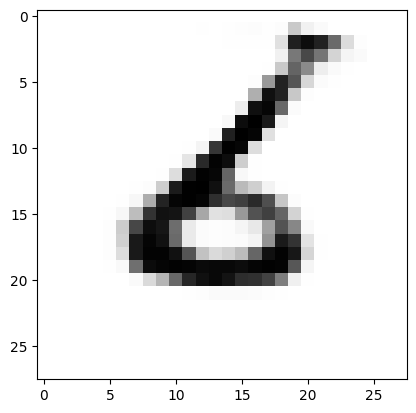

In [69]:
output, _, _ = model(img0.view(-1, 28 * 28).cuda())
plt.imshow(output.cpu().detach().view(28, 28), cmap='Greys')

## KLD and L1

In [107]:
model = vae.to('cuda')
optimizer = optim.Adadelta(model.parameters(), lr=1e1)
scheduler = ReduceLROnPlateau(optimizer, factor=0.1, patience=5, verbose=False, threshold=1e-3)

In [108]:
def train(model, train_loader, optimizer, epoch):
    model.train()
    allLoss = []
    allReconLoss = []
    with tqdm(train_loader, unit='batch') as tEpoch:
        for data, _ in tEpoch:
            data = data.to('cuda').view(-1, 28 * 28)
            optimizer.zero_grad()
            output, mu, log_var = model(data)
            reconLoss = L1Loss(output, data)
            loss = reconLoss + KLD(mu, log_var)
            loss.backward()
            optimizer.step()
            allLoss.append(loss.item())
            allReconLoss.append(reconLoss.item())
            tEpoch.set_postfix_str(' Epoch: {} \tTotal Loss: {:.6f}\tReconstruction Loss: {:.6f}\t lr: {:.8f}'.format(
                epoch, loss.item(), reconLoss.item(), optimizer.param_groups[0]['lr']))
    return allLoss, allReconLoss

In [109]:
for epoch in range(1, 201):
    _, loss = train(model, train_loader, optimizer, epoch)
    scheduler.step(np.mean(loss))

 49%|████▉     | 29/59 [00:02<00:02, 11.68batch/s,  Epoch: 3 	Total Loss: 0.126098	Reconstruction Loss: 0.126098	 lr: 0.10000000]


KeyboardInterrupt: 

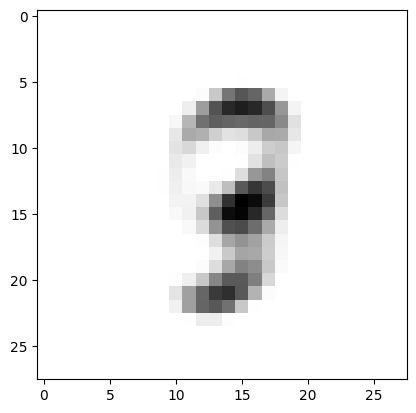

In [111]:
z = torch.normal(0, 1, size=(1, 64)).cuda()
plt.imshow(model.sample(z).cpu().detach().view(28, 28), cmap='Greys')